### pip installations

In [1]:
import numpy as np
# import starfysh
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from attr.validators import min_len
from scipy.spatial import procrustes
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import ot  # POT library for Optimal Transport
import matplotlib.pyplot as plt
from anndata import AnnData
# import starfysh
from matplotlib import pyplot as plt
from py_pcha import PCHA
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from itertools import permutations
# !pip install starfysh
# !pip install pandas 
# !pip install scanpy
# !pip install histomicstk
# !pip install --upgrade pip setuptools wheel
# !pip install pyvips --use-pep517
# !pip install histomicstk --find-links https://girder.github.io/large_image_wheels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

import bar_nick_utils
import importlib

importlib.reload(bar_nick_utils)

from bar_nick_utils import preprocess_rna, get_cell_representations_as_archetypes, preprocess_protein, plot_archetypes, \
get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal

# computationally figure out which ones are best
np.random.seed(8)

### reading in data

In [2]:
adata = sc.read("data/totalVI/spleen_lymph_cite_seq.h5ad")
adata = adata[adata.obs['batch'] == f'SLN111-D1']
# take subsampel of adata
fraction = 0.1
sc.pp.subsample(adata, fraction=fraction)
# adata.obsm['protein_expression'].columns.tolist()

/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
# Map the specific cell types to major cell types and add as a new column in obs
adata.obs['major_cell_types'] = pd.Categorical(adata.obs['cell_types'].map(cell_type_mapping))

In [4]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        432
CD4 T          189
CD8 T          142
cDCs            27
T cells         22
Macrophages     13
Treg            13
NK              10
Monocytes        9
Neutrophils      9
pDCs             4
RBC              3
Name: count, dtype: int64

In [5]:
# filtering cell types with low quantity
# need to add this filtering step to synthtic_data_generation.ipynb

# mask = adata.obs['major_cell_types'].isin(['Plasmacytoid dendritic cells', 'Red blood cells', 'Dendritic cells'])
# adata = adata[~mask]


In [6]:
adata.obs['major_cell_types'].value_counts()

major_cell_types
B cells        432
CD4 T          189
CD8 T          142
cDCs            27
T cells         22
Macrophages     13
Treg            13
NK              10
Monocytes        9
Neutrophils      9
pDCs             4
RBC              3
Name: count, dtype: int64

### starfysh analysis does not work

### using PCHA

### preprocessing rna

In [7]:
adata = preprocess_rna(adata, adata)

### preprocessing protein

In [8]:
adata.obsm['protein_expression'].shape
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
# assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# remove protein_expression from adatan/
adata_rna = adata.copy()
adata_rna.obsm.pop('protein_expression')
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
# take only the first batch from adata_prot and adata_rna
# first_batch = adata_prot.obs['batch'][0]
# take the largest batch 
# larget_batch = adata_prot.obs['batch'].value_counts().idxmax()

In [9]:
adata_prot = preprocess_protein(adata_prot)

In [10]:
adata = adata_prot

### analysis to get to scatter plot

In [11]:
adata

AnnData object with n_obs × n_vars = 873 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'major_cell_types', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'n_cells'

In [12]:
#  see pca var ratio


In [13]:
sc.pp.pca(adata, n_comps=10)
sc.pp.pca(adata_rna,n_comps=10)

# adata.uns['pca']['variance_ratio'][:10].sum()

In [14]:
archetype_list_protein = []
archetype_list_rna = []
converge=1e-5
min_k = 9
max_k = 14
step_size = 2

count = adata_prot.obsm['X_pca']
evs =[]
X_protein = count.T
total = (max_k-min_k)/step_size
for i, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total):
    archetype, _, _, _, ev = PCHA(X_protein, noc=k)
    evs.append(ev)
    archetype_list_protein.append(np.array(archetype).T)
    if i > 0 and ev - evs[i-1] < converge:
        print('early stopping')
        break
evs =[]
count = adata_rna.obsm['X_pca']
X_rna = count.T

for j, k in tqdm(enumerate(range(min_k, max_k, step_size)), total=total):
    if j>i:
        break
    archetype, _, _, _, ev = PCHA(X_rna, noc=k)
    evs.append(ev)
    archetype_list_rna.append(np.array(archetype).T)
    if j > 0 and ev - evs[j-1] < converge:
        # early stopping
        print('early stopping')
        break
min_len = min([len(archetype_list_protein),len(archetype_list_rna)])
archetype_list_protein = archetype_list_protein[:min_len]
archetype_list_rna = archetype_list_rna[:min_len]

3it [00:05,  1.69s/it]                         
3it [00:01,  1.78it/s]                         


In [15]:
# adata_prot.obsm['X_pca'],archetype_list_protein[0]
# adata_prot.obsm['X_pca'].shape

12

In [16]:
# send this for gene and protein as well as matching arrays over slack
# loop over prot and rna archetypes and get  weights for each loop over the archetypes
major_cell_types_list = sorted(list(set(adata_prot.obs['major_cell_types'])))
major_cell_types_amount_prot = [adata_prot.obs['major_cell_types'].value_counts()[cell_type] for cell_type in major_cell_types_list]
major_cell_types_amount_rna = [adata_rna.obs['major_cell_types'].value_counts()[cell_type] for cell_type in major_cell_types_list]
assert set(adata_rna.obs['major_cell_types']) == set(adata_prot.obs['major_cell_types'])
archetypes_prot_proportions,archetypes_ran_proportions = [],[]

# weights_prot = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetype_list_protein[0])
# weights_rna = get_cell_representations_as_archetypes(adata_rna.obsm['X_pca'], archetype_list_rna[0])
archetype_proportion_list = []

for archetypes_prot,archetypes_rna in zip(archetype_list_protein, archetype_list_rna):
    weights_prot = get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot)
    weights_rna = get_cell_representations_as_archetypes_cvxpy(adata_rna.obsm['X_pca'], archetypes_rna)
    archetypes_dim = archetypes_prot.shape[1]
    archetype_num = archetypes_prot.shape[0]
    prot_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))),columns=major_cell_types_list)
    rna_arch_prop = pd.DataFrame(np.zeros((archetype_num, len(major_cell_types_list))),columns=major_cell_types_list)
    archetype_cell_proportions = np.zeros((archetype_num, len(major_cell_types_list)))
    row_argmax_prot = np.argmax(weights_prot, axis=1)
    row_argmax_rna = np.argmax(weights_rna, axis=1)
    for curr_archetype in range(archetype_num):
        df_rna=pd.DataFrame([weights_prot[:,curr_archetype],adata_rna.obs['major_cell_types'].values],index=['weight','major_cell_types']).T
        df_prot=pd.DataFrame([weights_rna[:,curr_archetype],adata_prot.obs['major_cell_types'].values],index=['weight','major_cell_types']).T
        df_rna = df_rna.groupby('major_cell_types')['weight'].sum()
        df_prot = df_prot.groupby('major_cell_types')['weight'].sum()
        df_rna = df_rna[major_cell_types_list]
        df_prot = df_prot[major_cell_types_list]
        # cells_idx_belong_to_curr_archetype_rna = np.where(row_argmax_rna==curr_archetype)
        # cells_idx_belong_to_curr_archetype_prot = np.where(row_argmax_prot==curr_archetype)
        # archetype_proportion_rna = adata_rna[cells_idx_belong_to_curr_archetype_rna].obs['major_cell_types'].value_counts().to_dict()
        # archetype_proportion_prot = adata_prot[cells_idx_belong_to_curr_archetype_prot].obs['major_cell_types'].value_counts().to_dict()
        # normalize by the amount of major cell types
        rna_arch_prop.loc[curr_archetype,:] =df_rna.values/major_cell_types_amount_rna 
        prot_arch_prop.loc[curr_archetype,:] =df_prot.values/major_cell_types_amount_prot

    # rna_arch_prop.loc[curr_archetype] = rna_arch_prop.loc[curr_archetype] / rna_arch_prop.loc[curr_archetype].sum()
    print('asd')
    prot_arch_prop = (prot_arch_prop.T / prot_arch_prop.sum(1)).T
    prot_arch_prop = prot_arch_prop / prot_arch_prop.sum(0)
    rna_arch_prop = (rna_arch_prop.T / rna_arch_prop.sum(1)).T
    rna_arch_prop = rna_arch_prop / rna_arch_prop.sum(0)

    archetype_proportion_list.append([prot_arch_prop.copy(),rna_arch_prop.copy()])

asd


/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


asd
asd


2

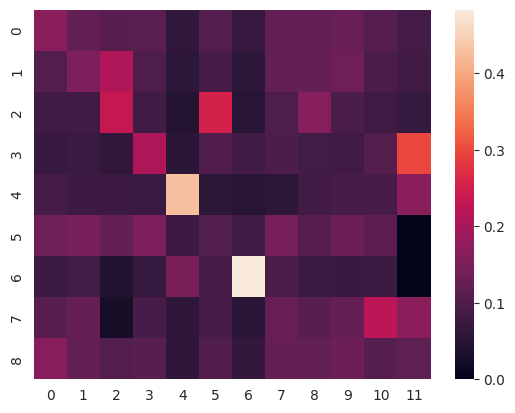

In [17]:
# normlize archetype_proportion_list cols
norm = archetype_proportion_list[0][0]
norm = (norm.T / norm.sum(1)).T
norm = norm / norm.sum(0)
sns.heatmap(reorder_rows_to_maximize_diagonal(norm.values)[0])
len(archetype_proportion_list[0])
# major_cell_types_amount 

In [18]:
def find_best_list_index_with_permutations(archetype_proportion_list, metric='euclidean'):
    """
    Find the best index in the lists of archetypes that gives the best one-to-one matching,
    normalized by the number of dimensions (M), while trying all permutations of dimensions.

    Parameters:
    -----------
    protein_list : list of np.ndarray
        List of protein archetypes, each of shape (10, M).
    rna_list : list of np.ndarray
        List of RNA archetypes, each of shape (10, M).
    metric : str, optional
        Metric to use for matching. Options: 'euclidean', 'cosine'.
        Default is 'euclidean'.

    Returns:
    --------
    best_index : int
        Index of the best matching pair in the lists.
    best_score : float
        Normalized matching score (cost per dimension) for the best pair.
    best_permutation : tuple
        The best permutation of RNA dimensions for the best pair.
    """
    best_score = float('inf')
    best_index = None
    best_permutation = None

    for i, (protein, rna) in enumerate((archetype_proportion_list)):
        # Ensure the number of dimensions matches for this pair
        protein = protein.values
        rna = rna.values
        assert protein.shape[1] == rna.shape[1], f"Mismatch in dimensions at index {i}."
        
        M = protein.shape[1]  # Number of dimensions
        best_pair_score = float('inf')
        best_pair_permutation = None
        # Try all permutations of RNA dimensions
        for perm in tqdm(permutations(range(M))):
            rna_permuted = rna[:, perm]  # Permute RNA dimensions
            
            # Compute the cost matrix between protein and permuted RNA
            cost_matrix = cdist(protein, rna_permuted, metric=metric)
            
            # Solve the assignment problem to find the one-to-one matching
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            
            # Calculate the total matching cost for this permutation
            total_cost = cost_matrix[row_ind, col_ind].sum()

            # Normalize the cost by the number of dimensions
            normalized_cost = total_cost / M

            # Update the best permutation for this pair
            if normalized_cost < best_pair_score:
                best_pair_score = normalized_cost
                best_pair_permutation = perm

        print(f"Pair {i}: Best normalized cost = {best_pair_score} with permutation {best_pair_permutation}")
        
        # Update the global best match if the current pair is better
        if best_pair_score < best_score:
            best_score = best_pair_score
            best_index = i
            best_permutation = best_pair_permutation

    return best_index, best_score, best_permutation


# Example usage
# Assuming archetype_list_protein and archetype_list_rna are your input lists
best_index, best_score, best_permutation = find_best_list_index_with_permutations(
    archetype_proportion_list, metric='euclidean'
)

print("\nBest pair found:")
print(f"Best index: {best_index}")
print(f"Best normalized matching score: {best_score}")
print(f"Best permutation of RNA dimensions: {best_permutation}")


1469446it [00:14, 103982.91it/s]


KeyboardInterrupt: 

In [41]:
import numpy as np

def greedy_dimension_matching(rna, protein, metric='l2'):
    """
    Match columns (dimensions) of RNA and protein matrices using a greedy algorithm.

    Parameters:
    -----------
    rna : np.ndarray
        RNA matrix, shape (n_samples, M).
    protein : np.ndarray
        Protein matrix, shape (n_samples, M).
    metric : str, optional
        Distance metric to use ('euclidean', 'l2', or 'cosine').

    Returns:
    --------
    mapping : list
        List of matched column indices in the protein matrix for each column in the RNA matrix.
    normalized_cost : float
        Total cost of the matching normalized by the number of archetypes (n_samples).
    """
    M = rna.shape[1]  # Number of dimensions
    n_samples = rna.shape[0]  # Number of archetypes (samples)
    available_protein_columns = list(range(M))
    mapping = []
    total_cost = 0.0

    rna_columns = [rna[:, i] for i in range(M)]
    print(f"Number of dimensions (M): {M}, Number of archetypes (n_samples): {n_samples}")

    for i in range(M):
        rna_col = rna_columns[i]
        # Compute distances to available protein columns
        protein_cols = [protein[:, j] for j in available_protein_columns]
        if metric in ('euclidean', 'l2'):
            distances = [np.linalg.norm(rna_col - protein_col) for protein_col in protein_cols]
        elif metric == 'cosine':
            distances = [
                1 - np.dot(rna_col, protein_col) / (np.linalg.norm(rna_col) * np.linalg.norm(protein_col))
                for protein_col in protein_cols
            ]
        else:
            raise ValueError("Unsupported metric. Use 'euclidean', 'l2', or 'cosine'.")

        # Find the best match
        min_index = np.argmin(distances)
        best_match = available_protein_columns[min_index]
        best_distance = distances[min_index]

        # Assign the match and remove the protein column from consideration
        mapping.append(best_match)
        available_protein_columns.pop(min_index)

        # Accumulate the cost
        total_cost += best_distance

    # Normalize the total cost by the number of archetypes (n_samples)
    normalized_cost = total_cost / n_samples

    return mapping, normalized_cost

def find_best_list_index_with_greedy_matching(archetype_proportion_list, metric='euclidean'):
    """
    Find the best index in the list using greedy dimension matching.

    Parameters:
    -----------
    archetype_proportion_list : list of tuples
        List where each tuple contains (rna, protein) matrices.
    metric : str, optional
        Distance metric to use ('euclidean', 'l2', or 'cosine').

    Returns:
    --------
    best_index : int
        Index of the best matching pair in the list.
    best_normalized_cost : float
        Total cost of the best matching normalized by the number of archetypes.
    best_mapping : list
        Best mapping of protein dimensions to RNA dimensions.
    """
    best_index = None
    best_normalized_cost = float('inf')
    best_mapping = None

    for i, (rna, protein) in enumerate(archetype_proportion_list):
        rna = rna.values if hasattr(rna, 'values') else rna
        protein = protein.values if hasattr(protein, 'values') else protein

        assert rna.shape[1] == protein.shape[1], f"Mismatch in dimensions at index {i}."

        mapping, normalized_cost = greedy_dimension_matching(rna, protein, metric=metric)
        print(f"Pair {i}: Normalized matching cost = {normalized_cost}, Mapping = {mapping}")

        if normalized_cost < best_normalized_cost:
            best_normalized_cost = normalized_cost
            best_index = i
            best_mapping = mapping

    return best_index, best_normalized_cost, best_mapping

# Assuming archetype_proportion_list is your input list
best_index, best_normalized_cost, best_mapping = find_best_list_index_with_greedy_matching(
    archetype_proportion_list, metric='euclidean'
)

print("\nBest pair found:")
print(f"Best index: {best_index}")
print(f"Best normalized matching cost: {best_normalized_cost}")
print(f"Best mapping of protein dimensions: {best_mapping}")


Number of dimensions (M): 12, Number of archetypes (n_samples): 9
Pair 0: Normalized matching cost = 0.2267932988560408, Mapping = [3, 11, 4, 10, 7, 8, 5, 6, 9, 0, 1, 2]
Number of dimensions (M): 12, Number of archetypes (n_samples): 11
Pair 1: Normalized matching cost = 0.22171040415188667, Mapping = [8, 11, 10, 7, 5, 0, 9, 1, 3, 6, 4, 2]
Number of dimensions (M): 12, Number of archetypes (n_samples): 13
Pair 2: Normalized matching cost = 0.23881567783688074, Mapping = [11, 8, 0, 1, 10, 9, 7, 3, 6, 2, 5, 4]

Best pair found:
Best index: 1
Best normalized matching cost: 0.22171040415188667
Best mapping of protein dimensions: [8, 11, 10, 7, 5, 0, 9, 1, 3, 6, 4, 2]


In [ ]:
best_rna, best_protein =  archetype_proportion_list[best_index]

norm = (norm.T / norm.sum(1)).T
norm = norm / norm.sum(0)
sns.heatmap(reorder_rows_to_maximize_diagonal(norm.values)[0])
len(archetype_proportion_list[0])
# major_cell_types_amount 

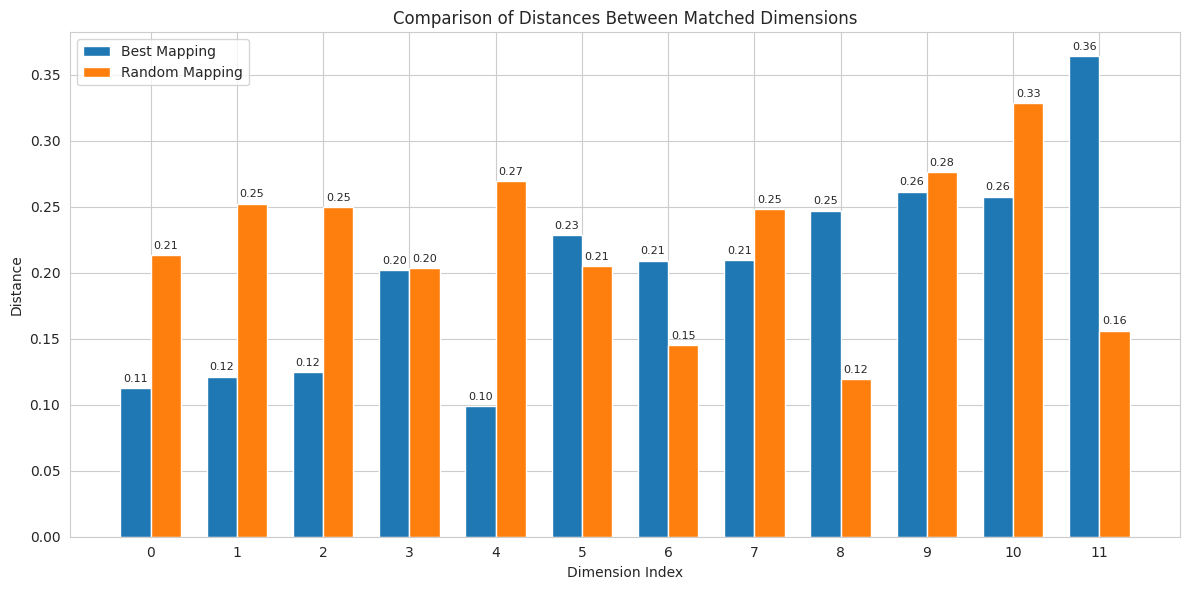

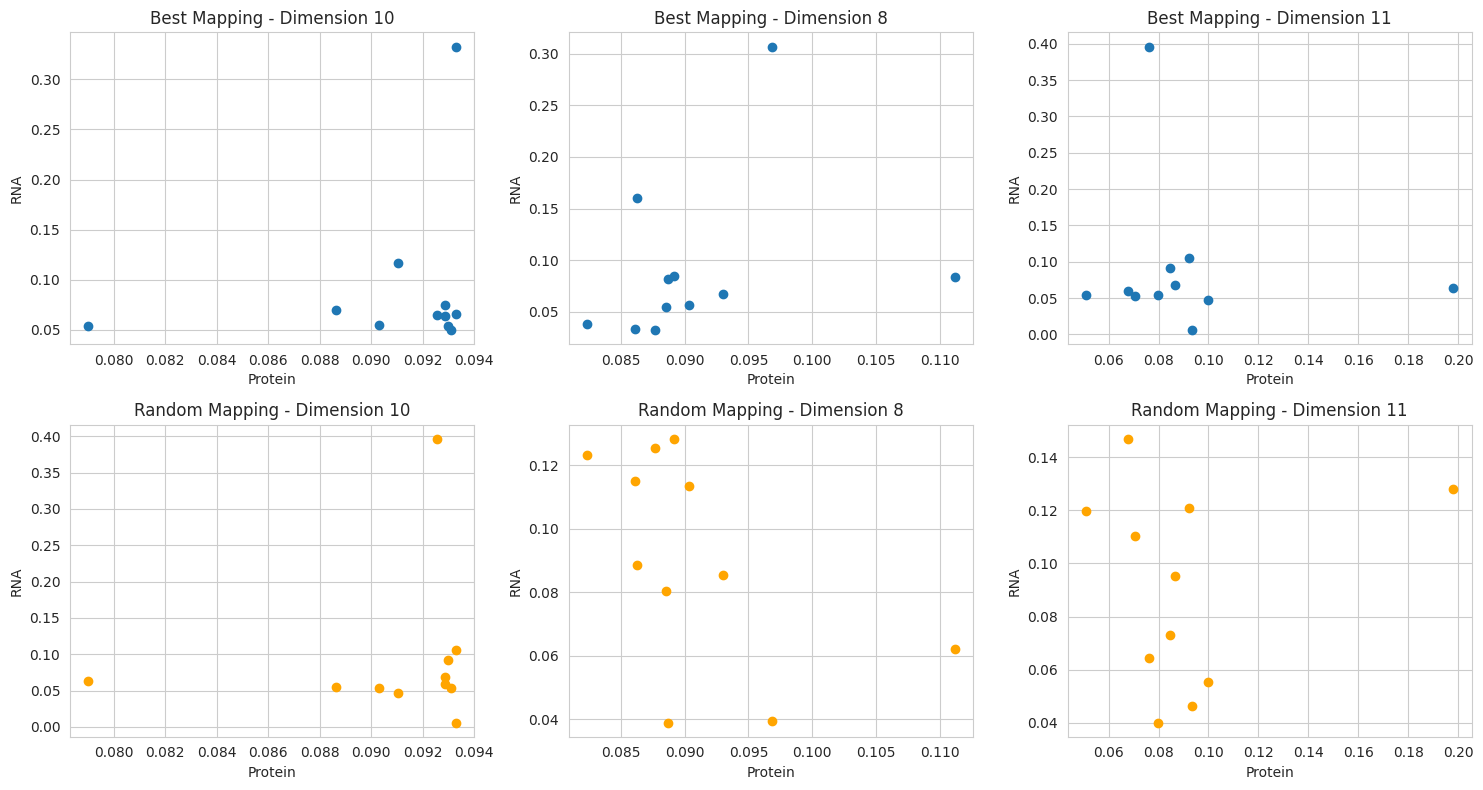

could not find match for archetypes of length 9 
could not find match for archetypes of length 11 
could not find match for archetypes of length 13 


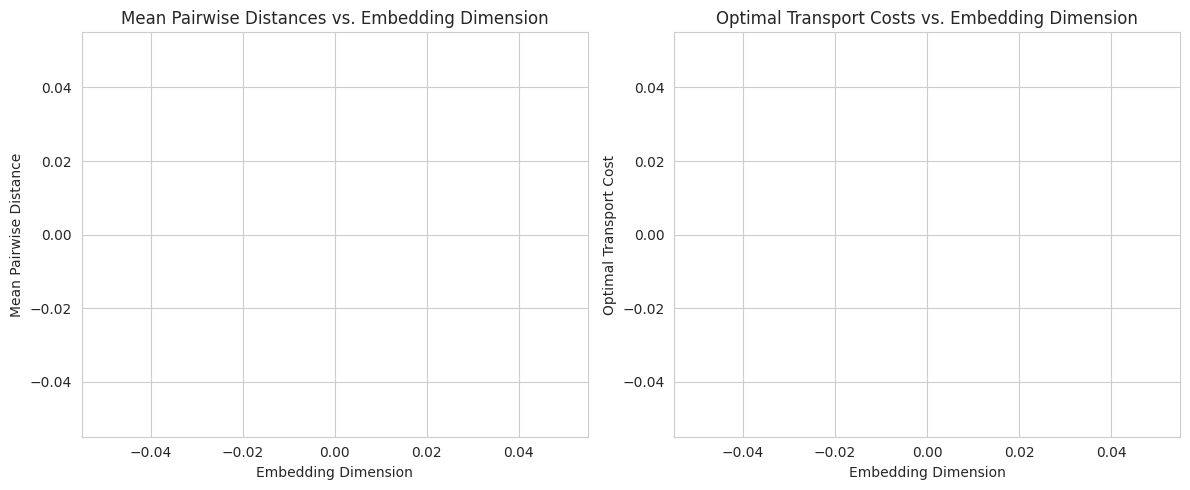

ValueError: attempt to get argmin of an empty sequence

In [136]:
embedding_dimensions = []  # Example dimensions from n to m
mean_pairwise_distances = []
ot_costs = []

# Number of samples in your datasets

# Loop over each embedding dimension
for archetypes_prot,archetypes_ran in (archetype_proportion_list):
    try:
        ds1_embeddings = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes_prot)
        ds2_embeddings = get_cell_representations_as_archetypes(adata_rna.obsm['X_pca'], archetypes_ran)
    except:
        print(f'could not find match for archetypes of length {len(archetypes_prot)} ')
        continue
    
    embedding_dimensions.append(len(archetypes_prot))
    n_samples = ds1_embeddings.shape[0]    
    # Standardize embeddings
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    ds1_embeddings = scaler1.fit_transform(ds1_embeddings)
    ds2_embeddings = scaler2.fit_transform(ds2_embeddings)
    
    # Step 2: Align Dimensions using Procrustes Analysis
    mtx1, mtx2, disparity = procrustes(ds1_embeddings, ds2_embeddings)
    # mtx1 and mtx2 are the aligned embeddings
    
    # Alternative: Align Dimensions using CCA
    # cca = CCA(n_components=dim)
    # ds1_embeddings_cca, ds2_embeddings_cca = cca.fit_transform(ds1_embeddings, ds2_embeddings)
    # Use ds1_embeddings_cca and ds2_embeddings_cca for further calculations
    
    # Step 3: Compute Pairwise Distances between corresponding samples
    pairwise_distances = np.linalg.norm(mtx1 - mtx2, axis=1)
    mean_distance = np.mean(pairwise_distances)
    mean_pairwise_distances.append(mean_distance)
    print(f"Mean Pairwise Distance: {mean_distance}")
    
    # Step 4: Compute Optimal Transport Cost
    # Create cost matrix between all samples (optional, since datasets are coupled)
    cost_matrix = cdist(mtx1, mtx2, metric='euclidean')
    
    # Since datasets are coupled, create uniform distributions
    a = np.ones(n_samples) / n_samples
    b = np.ones(n_samples) / n_samples
    
    # Compute OT cost using Sinkhorn algorithm
    lambda_reg = 1e-3  # Entropic regularization parameter
    ot_cost = ot.sinkhorn2(a, b, cost_matrix, lambda_reg)
    ot_costs.append(ot_cost)
    print(f"Optimal Transport Cost: {ot_cost}")
    print("-" * 50)

# Step 5: Compare Embedding Spaces
# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(embedding_dimensions, mean_pairwise_distances, marker='o')
plt.title('Mean Pairwise Distances vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Mean Pairwise Distance')

plt.subplot(1, 2, 2)
plt.plot(embedding_dimensions, ot_costs, marker='o', color='red')
plt.title('Optimal Transport Costs vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Optimal Transport Cost')

plt.tight_layout()
plt.show()

# Identify the best embedding space
best_dimension_index = np.argmin(mean_pairwise_distances)
best_embedding_dimension = embedding_dimensions[best_dimension_index]
print(f"The best embedding dimension based on mean pairwise distance is: {best_embedding_dimension}")

best_ot_index = np.argmin(ot_costs)
best_ot_dimension = embedding_dimensions[best_ot_index]
print(f"The best embedding dimension based on OT cost is: {best_ot_dimension}")


In [133]:
# np.unique(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot))
np.unique(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetypes_prot))

array([-0.48347573, -0.43239458, -0.37888594, ...,  0.98137199,
        1.01646059,  1.1050762 ])

In [135]:
def plot_scatter(mtx1, mtx2):
    pca = PCA(n_components=2)
    embeddings_combined = np.vstack((mtx1, mtx2))
    tsne_results = pca.fit_transform(embeddings_combined)
    # tsne_results = pca.fit_transform(embeddings_combined)

    labels = ['Dataset 1'] * n_samples + ['Dataset 2'] * n_samples
    df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    df['Dataset'] = labels

    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Dataset', data=df)
    plt.title('t-SNE of Aligned Embeddings')
    plt.show()



In [121]:

X = count.T
archetype, _, _, _, ev = PCHA(X, noc=len(set(adata.obs['major_cell_types'])))
# archetype = archetype.T
archetype.shape

(30, 12)

In [122]:
# # weights = get_cell_representations_as_archetypes(adata_prot.obsm['X_pca'], archetypes[-1].T)
# distances_array = []
# for arche in archetype:
#     distances = np.linalg.norm(adata_prot.obsm['X_pca']- arche, axis=1)
#     distances_array.append(distances)
# # np.linalg.norm(adata.obsm['X_pca'],archetype.T)
#     
# 
# # Columns: Cell 1 Cell 2 Cell 3 Cell 4
# # Row: anchor 
# # column, row distance from cell to anchor
# # we want minimum
# distances_array = np.array(distances_array)
# distances_array = distances_array.T
# row_argmin = np.argmin(distances_array, axis=1)
# adata.obs['archetype'] = row_argmin

### weights

In [137]:
# send this for gene and protein as well as matching arrays over slack
weights = get_cell_representations_as_archetypes_cvxpy(adata.obsm['X_pca'], archetype.T)
weights_df = pd.DataFrame(weights)
weights_df.to_csv("rna_weights.csv")
row_argmax = np.argmax(weights, axis=1)
adata.obs['corr_archetype'] = row_argmax
len(set((adata.obs['major_cell_types'])))


12

In [141]:
# set(list(adata.obs['major_cell_types']))
(set(cell_type_mapping.keys())) == ((set(adata.obs['cell_types'])))

False

In [142]:
# once I have indices, I want to check cell type for all of the indices
for dictionary in archetype_proportion_list:
    print(dictionary)


{}
{'cDCs': 1.0}
{'B cells': 0.5794392523364486, 'cDCs': 0.09345794392523364, 'T cells': 0.08411214953271028, 'Neutrophils': 0.06542056074766354, 'CD4 T': 0.04672897196261682, 'NK': 0.04672897196261682, 'Monocytes': 0.028037383177570093, 'Macrophages': 0.018691588785046728, 'RBC': 0.018691588785046728, 'Treg': 0.018691588785046728}
{}
{'CD4 T': 0.3854166666666667, 'B cells': 0.3125, 'Macrophages': 0.11458333333333333, 'Treg': 0.09375, 'CD8 T': 0.03125, 'cDCs': 0.020833333333333332, 'RBC': 0.010416666666666666, 'NK': 0.010416666666666666, 'T cells': 0.010416666666666666, 'pDCs': 0.010416666666666666}
{'NK': 0.2857142857142857, 'T cells': 0.2857142857142857, 'cDCs': 0.2857142857142857, 'Neutrophils': 0.14285714285714285}
{'Monocytes': 0.35714285714285715, 'T cells': 0.21428571428571427, 'pDCs': 0.21428571428571427, 'NK': 0.07142857142857142, 'Treg': 0.07142857142857142, 'cDCs': 0.07142857142857142}
{'B cells': 0.962457337883959, 'CD4 T': 0.020477815699658702, 'cDCs': 0.017064846416382253

In [143]:
# gene protein mapping
gene_mapping = ['Monocytes', 'T cells-2', 'T cells-1', 'Macrophages', 'Neutrophils', 'Red blood cells',
                'Natural killer cells', 'Conventional dendritic cells', 'Regulatory T cells', 'Dendritic cells',
                'Natural killer T cells', 'Plasmacytoid dendritic cells', 'B cells']

In [144]:
# final protein mapping
protein_mapping = ['Red blood cells', 'T cells-2', 'Plasmacytoid dendritic cells', 'Natural killer T cells',
                   'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes',
                   'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1']

In [145]:
assert len(protein_mapping) == len(set(protein_mapping))

In [146]:
# protein_mapping = ['Red blood cells', 'Natural killer T cells', 'T cells-2', 'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1']

In [147]:
# MUST SAVE
# protein_mapping = ['Red blood cells','Plasmacytoid dendritic cells', 'T cells-2','Natural killer cells', 'Natural killer T cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells','B cells', 'T cells-1' ]

print(len(set(list(protein_mapping))))

13


In [30]:
for i in set(adata.obs['major_cell_types']):
    if i not in gene_mapping:
        print(i)
# print(len(protein_mapping))
# print(len(set(protein_mapping)))

NameError: name 'gene_mapping' is not defined

In [150]:
cell_type_mapping_order = sorted(set(cell_type_mapping.values()))  # order that we set dimensions

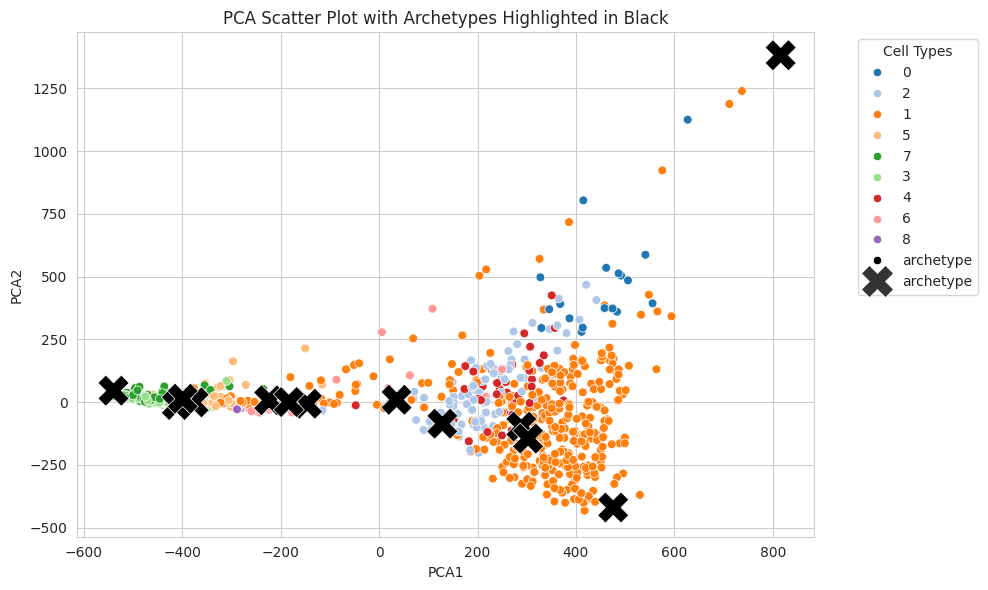

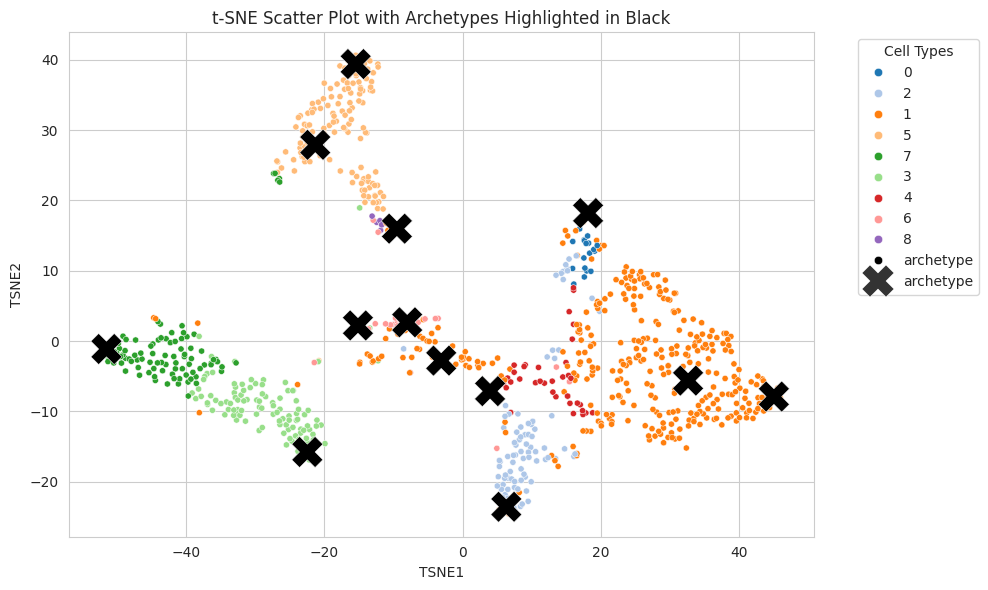

In [31]:
data_points = adata.obsm['X_pca']
samples_cell_types = list(pd.Categorical(adata.obs['cell_types']))
samples_cell_types = list(pd.Categorical(adata.obs['major_cell_types']))
# samples_cell_types = list(adata.obs['corr_archetype'].astype(str)) #  to see the most correlated cells to each archetype
archetype = archetype_list_protein[2]
samples_cell_types = list(np.argmax(get_cell_representations_as_archetypes_cvxpy(adata_prot.obsm['X_pca'], archetype_list_protein[0]),axis=1).astype(np.str_))
plot_archetypes(data_points,archetype,samples_cell_types)
plot_archetypes(data_points,archetype,samples_cell_types)


In [153]:
# sc.pl.pca(adata, color='major_cell_types')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


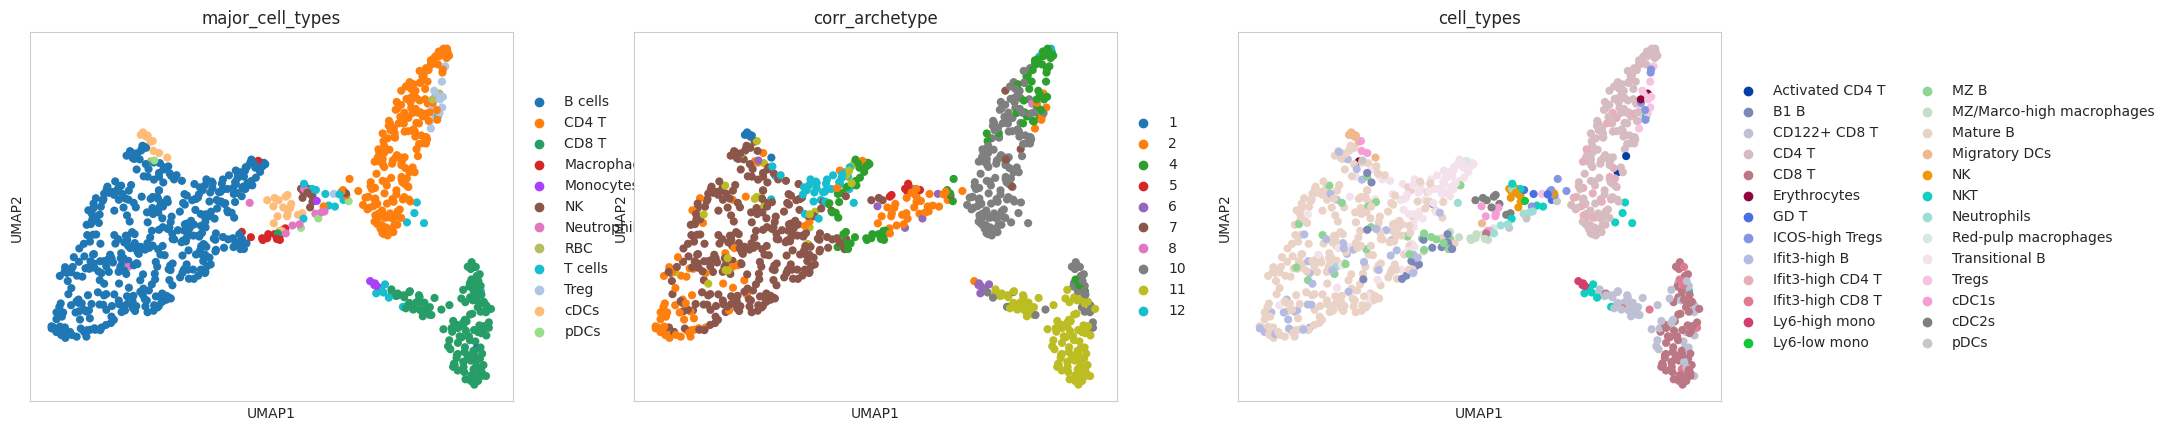

In [154]:
# adata.obs['archetype'] = pd.Categorical(adata.obs['archetype'])
adata.obs['corr_archetype'] = pd.Categorical(adata.obs['corr_archetype'])
sc.pl.umap(adata, color=['major_cell_types', 'corr_archetype', 'cell_types'])


In [ ]:
sc.pl.pca(adata, color=['archetype', 'major_cell_types', 'corr_archetype', 'cell_types'])


In [ ]:
sc.pl.umap(adata, color='major_cell_types', title='Protein Major Cell Types')

In [ ]:
sc.pl.umap(adata, color='cell_types', title='Protein Minor Cell Types')

In [ ]:
archetypes[-1].shape
# two samples, first dimension: x, second dimension: y

In [ ]:
sc.pl.pca(adata_slice, color='')

In [ ]:
adata.uns['cell_types'] = adata.obs['cell_types']